In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)
from torch import cuda
from lib.dataset_utils import *
from lib.plot_utils import *
from lib.models import *
from sklearn.metrics import accuracy_score, jaccard_score, f1_score
import matplotlib.pyplot as plt

- Minibatch
- learning rate
- momentum
- regularization
- dropout?
- topologia
- optimizer?

In [2]:
# Defining some key variables that will be used later on in the training
DATASET_NAME = DatasetEnum.GoEmotionsCleaned
MINIBATCH_SIZE = 16
EPOCHS = 1
LEARNING_RATE = 5e-05
FROZEN_LAYERS = 9
loader_params = {'batch_size': MINIBATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
train_df, val_df, test_df = load_dataset(DATASET_NAME)
MAX_LEN = compute_max_tokens([train_df, val_df, test_df], RobertaTokenizer.from_pretrained('roberta-base'))

In [3]:
train_df.head()

,text,admiration,amusement,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,...,sadness,surprise,neutral,annoyance,approval,caring,confusion,curiosity,desire,disappointment
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,WHY THE FUCK IS BAYLESS ISOING,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [4]:
THRESHOLD = 0.5
# tuning implicitly done in score calculation :)
def accuracy(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, accuracy_score)
    return best_res

def jaccard(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, jaccard_score, {'average': 'macro'})
    return best_res

def jaccard_samples(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, jaccard_score, {'average': 'samples'})
    return best_res

def f1(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, f1_score, {'average': 'macro'})
    return best_res

def f1_micro(y_true, y_pred):
    _, best_res = tune_sigmoid_threshold(y_true, y_pred, f1_score, {'average': 'micro'})
    return best_res

In [5]:
model = SimpleModelInterface(RobertaClass(train_df.shape[1]-1), {'accuracy': accuracy, 'jaccard_macro': jaccard, 'f1_macro': f1, 'jaccard_samples': jaccard_samples, 'f1_micro':f1_micro}, create_model_params(tokenizer_max_len=MAX_LEN))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
model.fit(train_df[:1000])

125it [00:46,  2.69it/s]


In [7]:
scores = model.evaluate(test_df[:1000])
scores

125it [00:14,  8.85it/s]


{'accuracy': 0.301,
 'jaccard_macro': 0.041321428571428565,
 'f1_macro': 0.0741173072984191,
 'jaccard_samples': 0.319,
 'f1_micro': 0.31247102457116366}

In [8]:
out = model.predict(test_df[:1000])
target = test_df[:1000].iloc[:, 1:].values

125it [00:14,  8.77it/s]


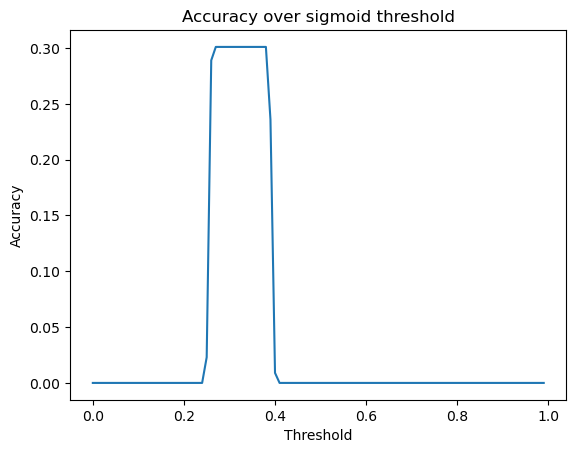

Best threshold: 0.27
Best Accuracy: 0.301


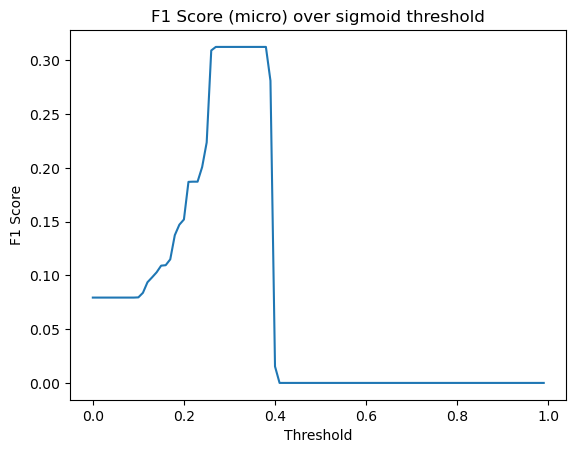

Best threshold: 0.27
Best F1 Score (micro): 0.31247102457116366


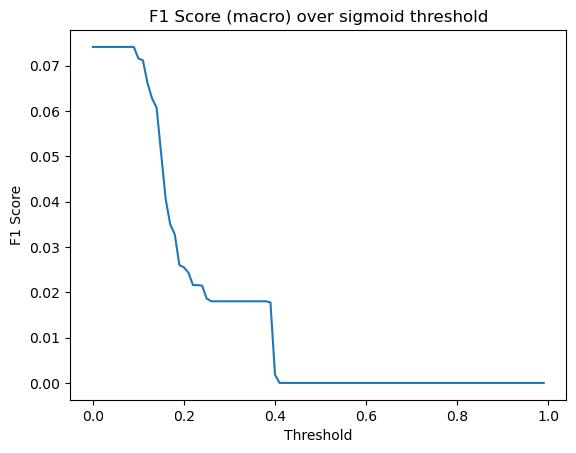

Best threshold: 0.0
Best F1 Score (macro): 0.0741173072984191


In [9]:
plot_threshold_tuning(target, out, plot=True)
plot_threshold_tuning(target, out, plot=True, metric_params={'average':'micro'}, metric_fun=f1_score, metric_name='F1 Score')
plot_threshold_tuning(target, out, plot=True, metric_params={'average':'macro'}, metric_fun=f1_score, metric_name='F1 Score')